In [1]:
# Allow reload of objects
%load_ext autoreload
%autoreload
from pelenet.utils import Utils
from pelenet.experiments.readout import ReadoutExperiment

# Official modules
import numpy as np
import nxsdk.api.n2a as nx
import matplotlib
import matplotlib.pyplot as plt
import os
from time import time

In [2]:
# Initilizes the experiment and utils
utils = Utils.instance()
exp = ReadoutExperiment()

In [3]:
# Build network
exp.build()

# Get spectral radius
utils.getSpectralRadius(exp.net.initialWeights)

1.948

In [4]:
# Run network
exp.run()

INFO:DRV:  Connecting to 127.0.0.1:33523
INFO:DRV:      Host server up..............Done 0.05s
INFO:DRV:      Encoding axons/synapses.....Done 12.85s
Compiling in directory : /home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1580827700.8508937
Include dir is : /home/seq/05-reward/v0.x/pelenet/snips/ -I/home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/nxsdk/graph/nxinputgen/../../snips/
Compiling -c /home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1580827700.8508937/initnetwork_0_0.c
gcc -Wall -I/home/seq/05-reward/v0.x/pelenet/snips/ -I/home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/nxsdk/graph/nxinputgen/../../snips/ -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -st

INFO:DRV:      Compiling Embedded snips....Done 0.59s
INFO:HST:  Using Kapoho Bay serial number 308
INFO:HST:  Args chip=0 cpu=0 /home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1580827700.8508937/launcher_chip0_lmt0.bin --chips=2 --remote-relay=0 --epoch=0 
INFO:HST:  Args chip=1 cpu=0 /home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1580827700.8508937/launcher_chip1_lmt0.bin --chips=2 --remote-relay=0 --epoch=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 1.58s
INFO:DRV:      Encoding probes.............Done 8.32ms
INFO:DRV:      Configuring registers.......Done 12.15s
INFO:DRV:      Transferring probes.........Done 0.02s
INFO:DRV:      Transferring spikes.........Done 9.23ms
INFO:HST:  chip=1 cpu=0 Transfered values 20, 250, 30 
INFO:HST:  chip=0 cpu=0 Transfered values 20, 250, 30 
INFO:HST:  chip=0 cpu=0 Reset current/vol

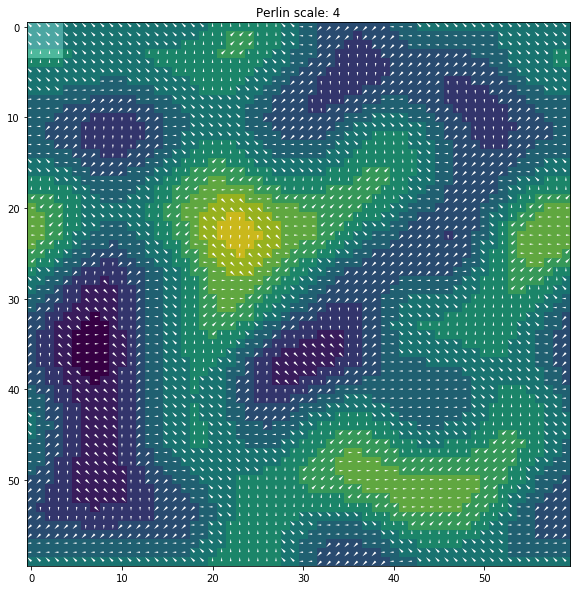

In [5]:
exp.net.plot.landscape()

In [6]:
#p = exp.net.exVoltageProbes[0].plot()

In [7]:
#p = exp.net.inVoltageProbes[0].plot()

In [8]:
#exp.net.plot.reservoirSpikeTrain(fr=260, to=300)

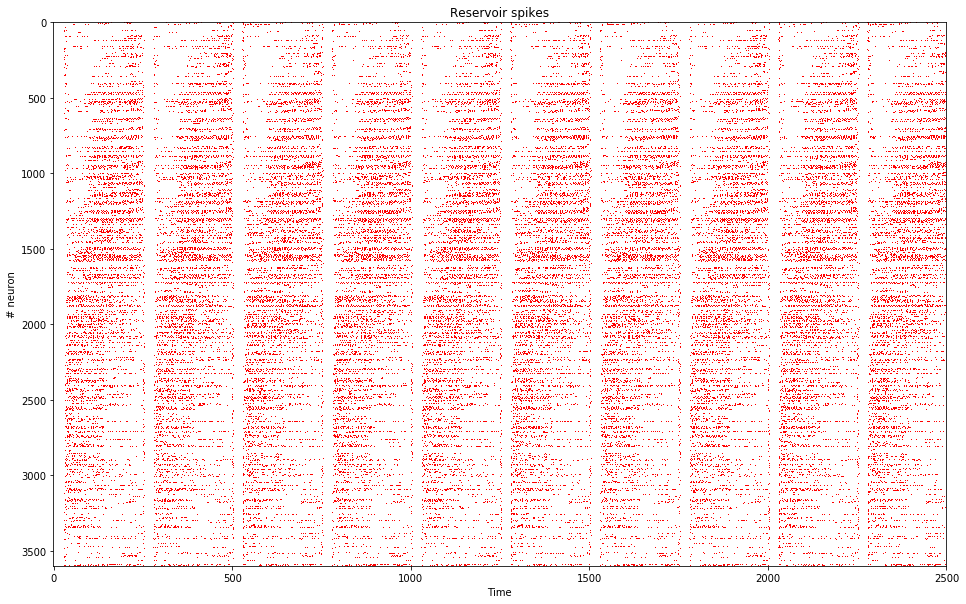

In [9]:
exp.net.plot.reservoirSpikeTrain()

In [10]:
for i in range(exp.p.trials):
    fr = exp.p.breakSteps+i*exp.p.totalTrialSteps
    print(np.sum([exp.net.exSpikeProbes[j].data[:,fr:fr+10] for j in range(len(exp.net.exSpikeProbes))], axis=(0,1)))

[ 16  23 144 496 362 325 303 386 352 491]
[ 16  23 144 496 362 325 303 386 352 491]
[ 16  23 144 496 362 325 303 386 352 491]
[ 16  23 144 496 362 325 303 386 352 491]
[ 16  23 144 496 362 325 303 386 352 491]
[ 16  23 144 496 362 325 303 386 352 491]
[ 16  23 144 496 362 325 303 386 352 491]
[ 16  23 144 496 362 325 303 386 352 491]
[ 16  23 144 496 362 325 303 386 352 491]
[ 16  23 144 496 362 325 303 386 352 491]


In [11]:
print(exp.net.cueSpikes[0])
print(exp.net.cueSpikes[1])

[31, 280, 281, 530, 531, 780, 1030, 1031, 1280, 1281, 1530, 1531, 1780, 1781, 2030, 2031, 2280, 2281]
[30, 31, 280, 281, 530, 531, 780, 781, 1030, 1031, 1280, 1281, 1530, 1531, 1780, 1781, 2031, 2280, 2281]


In [12]:
fs = []
for i in range(len(exp.net.cueSpikes)):
    cs = np.array(exp.net.cueSpikes[i])
    fs.extend(cs[np.logical_and(cs < 50, cs < 300)])
print(len(fs))

114


In [13]:
print(exp.p.breakSteps)
print(exp.p.trialSteps)
print(exp.p.totalTrialSteps)
print(exp.p.totalSteps)

30
220
250
2500


In [14]:
i = 20
print(np.sum(exp.net.exSpikeProbes[i].data[:,exp.p.breakSteps:exp.p.totalTrialSteps]))
print(np.sum(exp.net.exSpikeProbes[i].data[:,exp.p.breakSteps+exp.p.totalTrialSteps:2*exp.p.totalTrialSteps]))
print(np.sum(exp.net.exSpikeProbes[i].data[:,exp.p.breakSteps+2*exp.p.totalTrialSteps:3*exp.p.totalTrialSteps]))
print(np.sum(exp.net.exSpikeProbes[i].data[:,exp.p.breakSteps+3*exp.p.totalTrialSteps:4*exp.p.totalTrialSteps]))

598
598
598
598


In [15]:
offset = exp.p.breakSteps + exp.p.cueSteps + exp.p.cueRelaxation
data = []
for i in range(exp.p.trials):
    fr, to = (i+1)*offset+i*exp.p.movementSteps, (i+1)*offset+(i+1)*exp.p.movementSteps
    data.append(exp.net.exSpikeTrains[:,fr:to])
data = np.array(data)
shp = data.shape
shp

(10, 3600, 200)

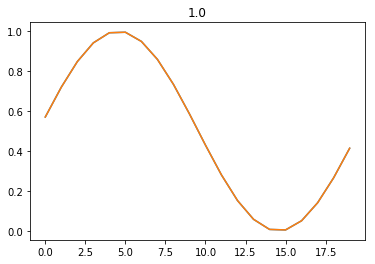

In [16]:
binSize = 10
(params, ye, performance) = utils.trainOLS(data[:9], data[9], exp.targetFunction, filter='bins', binSize=binSize)

plt.title(performance.cor)
plt.plot(ye)
plt.plot(np.array([np.mean(exp.targetFunction[i:i+binSize]) for i in range(0,len(exp.targetFunction),binSize)]))
p = plt.show()

In [17]:
dtrans = []
for i in range(data.shape[0]):
    dataBinned = np.array([np.mean(data[i, :, j:j+binSize], axis=1) for j in range(0,data[i].shape[1],binSize)])
    (d, evals, evecs) = utils.pca(dataBinned.astype(float), dims_rescaled_data=1)
    dtrans.append(d)

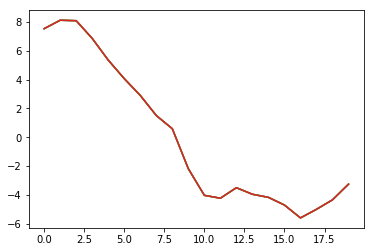

In [18]:
plt.plot(dtrans[0])
plt.plot(dtrans[1])
plt.plot(dtrans[2])
plt.plot(dtrans[3])

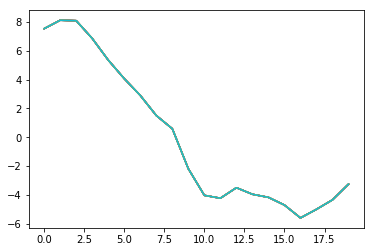

In [19]:
for i in range(data.shape[0]):
    plt.plot(dtrans[i])

In [20]:
#import subprocess
#subprocess.call(shlex.split("jupyter nbconvert notebook.ipynb --to pdf"))